# Create Deep Learning (Sequential Model) Instance from Scratch

In [3]:
from random import sample
from time import time
from collections import defaultdict

import matplotlib.pyplot as plt

import numpy as np

## Loading and preprocessing MNIST

In [4]:
from sklearn.datasets import fetch_openml

# Load MNIST data from https://www.openml.org/d/554
X, Y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [5]:
# normalize dataset -> [-1, 1]
X = X/255*2-1

# create traininig and validation data
n_train, n_val = 9216, 1024
ids = np.random.choice(range(X.shape[0]), n_train+n_val, replace=False)
id_train, id_val = ids[:-n_val], ids[-n_val:]
X_train, X_val = X[id_train, :], X[id_val, :]
X_train = np.vstack([X_train.T, np.ones((1,n_train))])
X_val = np.vstack([X_val.T, np.ones((1,n_val))])

d = 784
C=10

# create Y (both label and one-hot versiton)
Y = Y.astype(int)
Y_train, Y_val = Y[id_train], Y[id_val]
Y_one_hot_train = np.zeros((C, n_train))
Y_one_hot_val = np.zeros((C, n_val))
Y_one_hot_train[Y_train, np.arange(n_train)] = 1
Y_one_hot_val[Y_val, np.arange(n_val)] = 1

# create test data
n_test = 2000

id_all_mask = np.ones(X.shape[0])
id_all_mask[id_train] = 0
id_all_mask[id_val] = 0
id_test = np.random.choice(np.arange(X.shape[0])[id_all_mask==1], n_test, replace=False)

X_test = np.vstack([X[id_test, :].T, np.ones((1,n_test))])
Y_test = Y[id_test]

## Loss / Activation Functions
- sigmoid
- softmax
- cross_entropy_with_softmax

In [6]:
# sigmoid
sigmoid = lambda x:1/(1+np.exp(-x))

# softmax
def softmax(Z):
    Z = np.exp(Z)
    return Z / Z.sum(0)

# cross entropy with softmax
def cross_entropy_with_softmax(Y, P):
    return -np.log(softmax(P)[Y, np.arange(len(Y))])

# h(x) -> [x, 1]^T (to include bias term in matrix multiplication)
def h(x):
    x2 = np.ones((x.shape[0]+1, x.shape[1]))
    x2[:-1,:] = x
    return x2

# gradients
def grad_sigmoid(v):
    return sigmoid(v) * (1-sigmoid(v))

def grad_cross_entropy_with_softmax(t, y):
    return y-t

## Simple Two Layers Network

In [7]:
"""
二層のネットワーク
- hidden: 64, sigmoid
- final: 10, softmax + cross entropy
- 学習率はannealingで調整

- backwardは直前の出力値をそのまま使うので、必ずforwardの直後にbackwardをする（途中でpredictを挟まない）ことに注意
- backwardの直後にupdateを行うこと。直前のbackwardの数値をそのまま使うため。
"""
M = 64

class Net:
    def __init__(self, lr=lambda epoch: (1e-2)/(1+epoch/8)):
        self.W1 = np.random.normal(0, 1e-3, (M, d+1))
        self.W2 = np.random.normal(0, 1e-3, (C, M+1))
        self.lr = lr
        
    def forward(self, x):
        self.x = x
        self.z1 = self.W1 @ h(x)
        self.a1 = h(sigmoid(self.z1))
        self.z2 = self.W2 @ self.a1
        self.y = softmax(self.z2)
        return self.z2
    
    def backward(self, t):
        delta_2 =  grad_cross_entropy_with_softmax(t, self.y)
        self.grad_W2 = delta_2 @ h(sigmoid(self.z1)).T
        delta_1 = (self.W2[:,:-1].T @ delta_2) * grad_sigmoid(self.z1)
        self.grad_W1 = delta_1 @ h(self.x).T
        
    def update(self, epoch):
        self.W2 -= self.lr(epoch)*self.grad_W2
        self.W1 -= self.lr(epoch)*self.grad_W1
        
    def predict(self, x):
        self.forward(x)
        return self.y.argmax(axis=0)

In [45]:
# check gradients with numerical differentiation

net = Net()
i,j = 0,0

# 一回forward, backwardを回すことでgradが記録される
net.forward(X_train[:-1, :1])
net.backward(Y_one_hot_train[:, 0].reshape(-1,1))

# backpropagationの値
print("by backpropagation: ", net.grad_W2[i, j])

# numerical differentiation
eps = 1e-3
net.W2[i,j] += eps
L1 = cross_entropy_with_softmax(Y_train[:1], net.forward(X_train[:-1, :1])) 
net.W2[i,j] -= 2*eps
L2 = cross_entropy_with_softmax(Y_train[:1], net.forward(X_train[:-1, :1]))
net.W2[i,j] += eps

grad = (L1-L2)/(2*eps)
print("by numerical differentiation: ", *grad)

by backpropagation:  0.04885896077042717
by numerical differentiation:  0.048858962182762866


In [9]:
# Learning

n_epoch=64
batch_size=128

net = Net()

result = {"accuracy": np.zeros((n_epoch, n_train//batch_size)),
         "loss": np.zeros((n_epoch, n_train//batch_size)),
         "accuracy_val": np.zeros(n_epoch),
         "loss_val": np.zeros(n_epoch)}

best_acc = 0
best_weight = -1
for ep in range(n_epoch):
    for i in range(n_train//batch_size):
        X_batch = X_train[:-1, i*batch_size:(i+1)*batch_size]
        Y_batch = Y_train[i*batch_size:(i+1)*batch_size]
        Y_one_hot_batch = Y_one_hot_train[:, i*batch_size:(i+1)*batch_size]
        
        # この３つは必ず連続して行う
        net.forward(X_batch)
        net.backward(Y_one_hot_batch)
        net.update(ep)
        
        # accuracy on training batch
        pred = softmax(net.forward(X_batch))
        acc = (pred.argmax(axis=0)==Y_batch).mean()
        loss = cross_entropy_with_softmax(Y_batch, pred).sum() / batch_size / C
        
        result["accuracy"][ep][i] = acc
        result["loss"][ep][i] = loss
        
    # validation
    pred = softmax(net.forward(X_val[:-1,:]))
    acc = (pred.argmax(axis=0)==Y_val).mean()
    loss = cross_entropy_with_softmax(Y_val, pred).sum() / len(Y_val) / C
    
    result["accuracy_val"][ep] = acc
    result["loss_val"][ep] = loss
    
    print(f"{ep}-th epoch")
    print("Validation Accuracy: ", acc)
    print("Validation Loss: ", loss)
    
    # save best weight
    if acc > best_acc:
        best_acc = acc
        best_weight = [net.W1.copy(), net.W2.copy()]

0-th epoch
Validation Accuracy:  0.3544921875
Validation Loss:  0.21428350139358146
1-th epoch
Validation Accuracy:  0.7265625
Validation Loss:  0.1868484759067004
2-th epoch
Validation Accuracy:  0.7197265625
Validation Loss:  0.17862614675790267
3-th epoch
Validation Accuracy:  0.8642578125
Validation Loss:  0.1646622854386365
4-th epoch
Validation Accuracy:  0.8916015625
Validation Loss:  0.16162752244086104
5-th epoch
Validation Accuracy:  0.8974609375
Validation Loss:  0.1607304016025855
6-th epoch
Validation Accuracy:  0.9033203125
Validation Loss:  0.15964596539693546
7-th epoch
Validation Accuracy:  0.91015625
Validation Loss:  0.158916334163934
8-th epoch
Validation Accuracy:  0.9189453125
Validation Loss:  0.15838444689132844
9-th epoch
Validation Accuracy:  0.9189453125
Validation Loss:  0.15796526602121858
10-th epoch
Validation Accuracy:  0.921875
Validation Loss:  0.15761113849582525
11-th epoch
Validation Accuracy:  0.923828125
Validation Loss:  0.15730889086825128
12-th

### Accuracy and Loss of each iteration of the same epochs

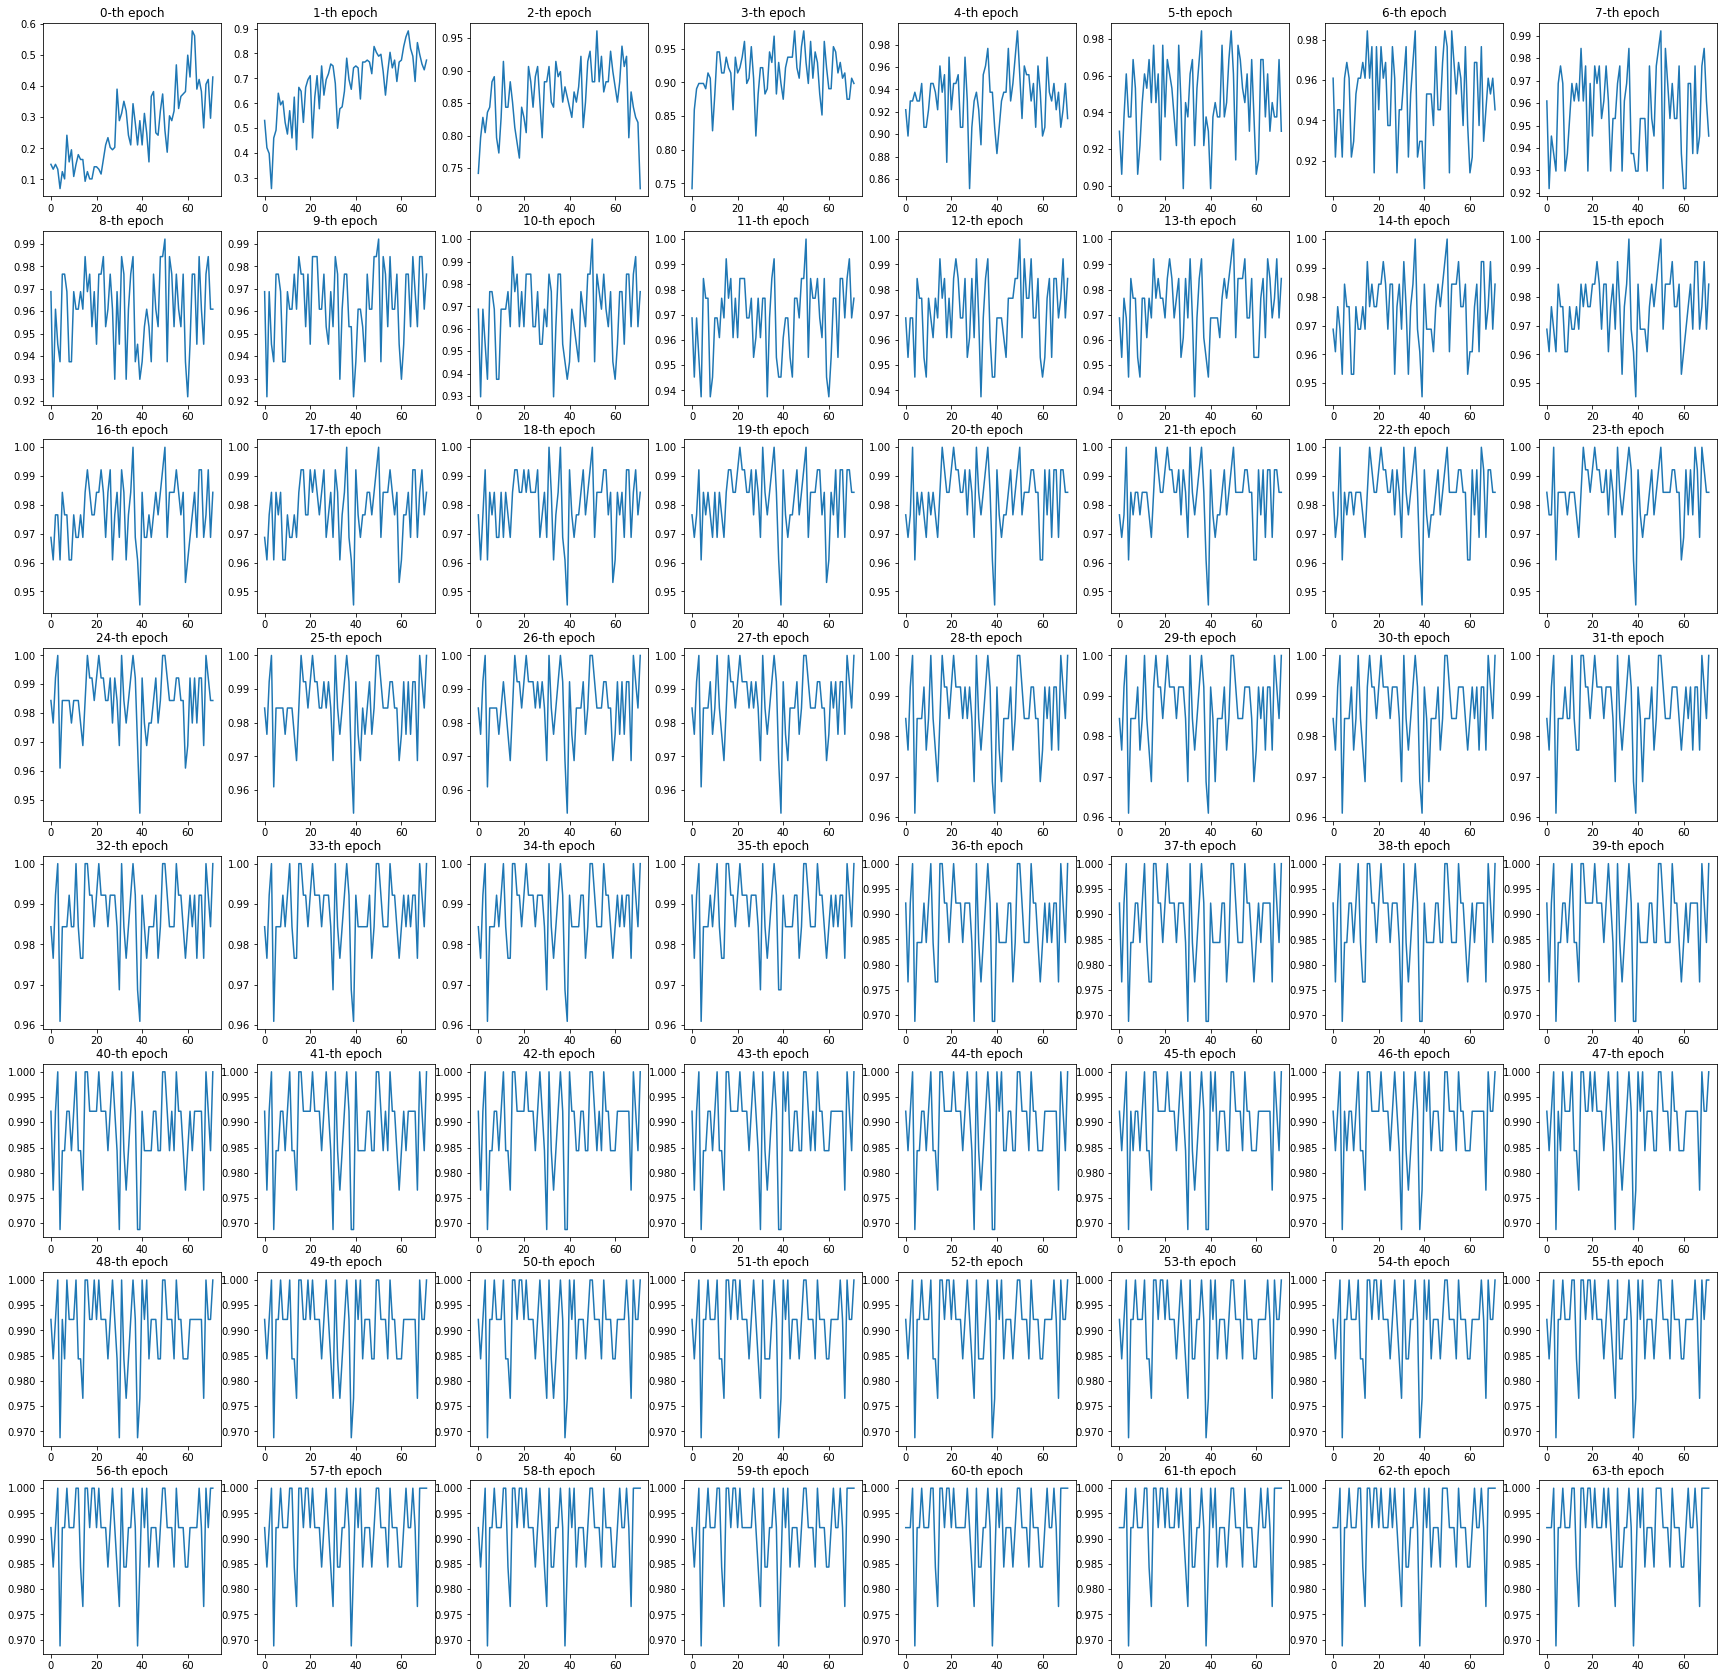

In [10]:
fig,axes = plt.subplots(8,8,figsize=(30,30))

for ep in range(64):
    row, col = divmod(ep, 8)
    axes[row, col].plot(result["accuracy"][ep])
    axes[row, col].set_title(f"{ep}-th epoch")

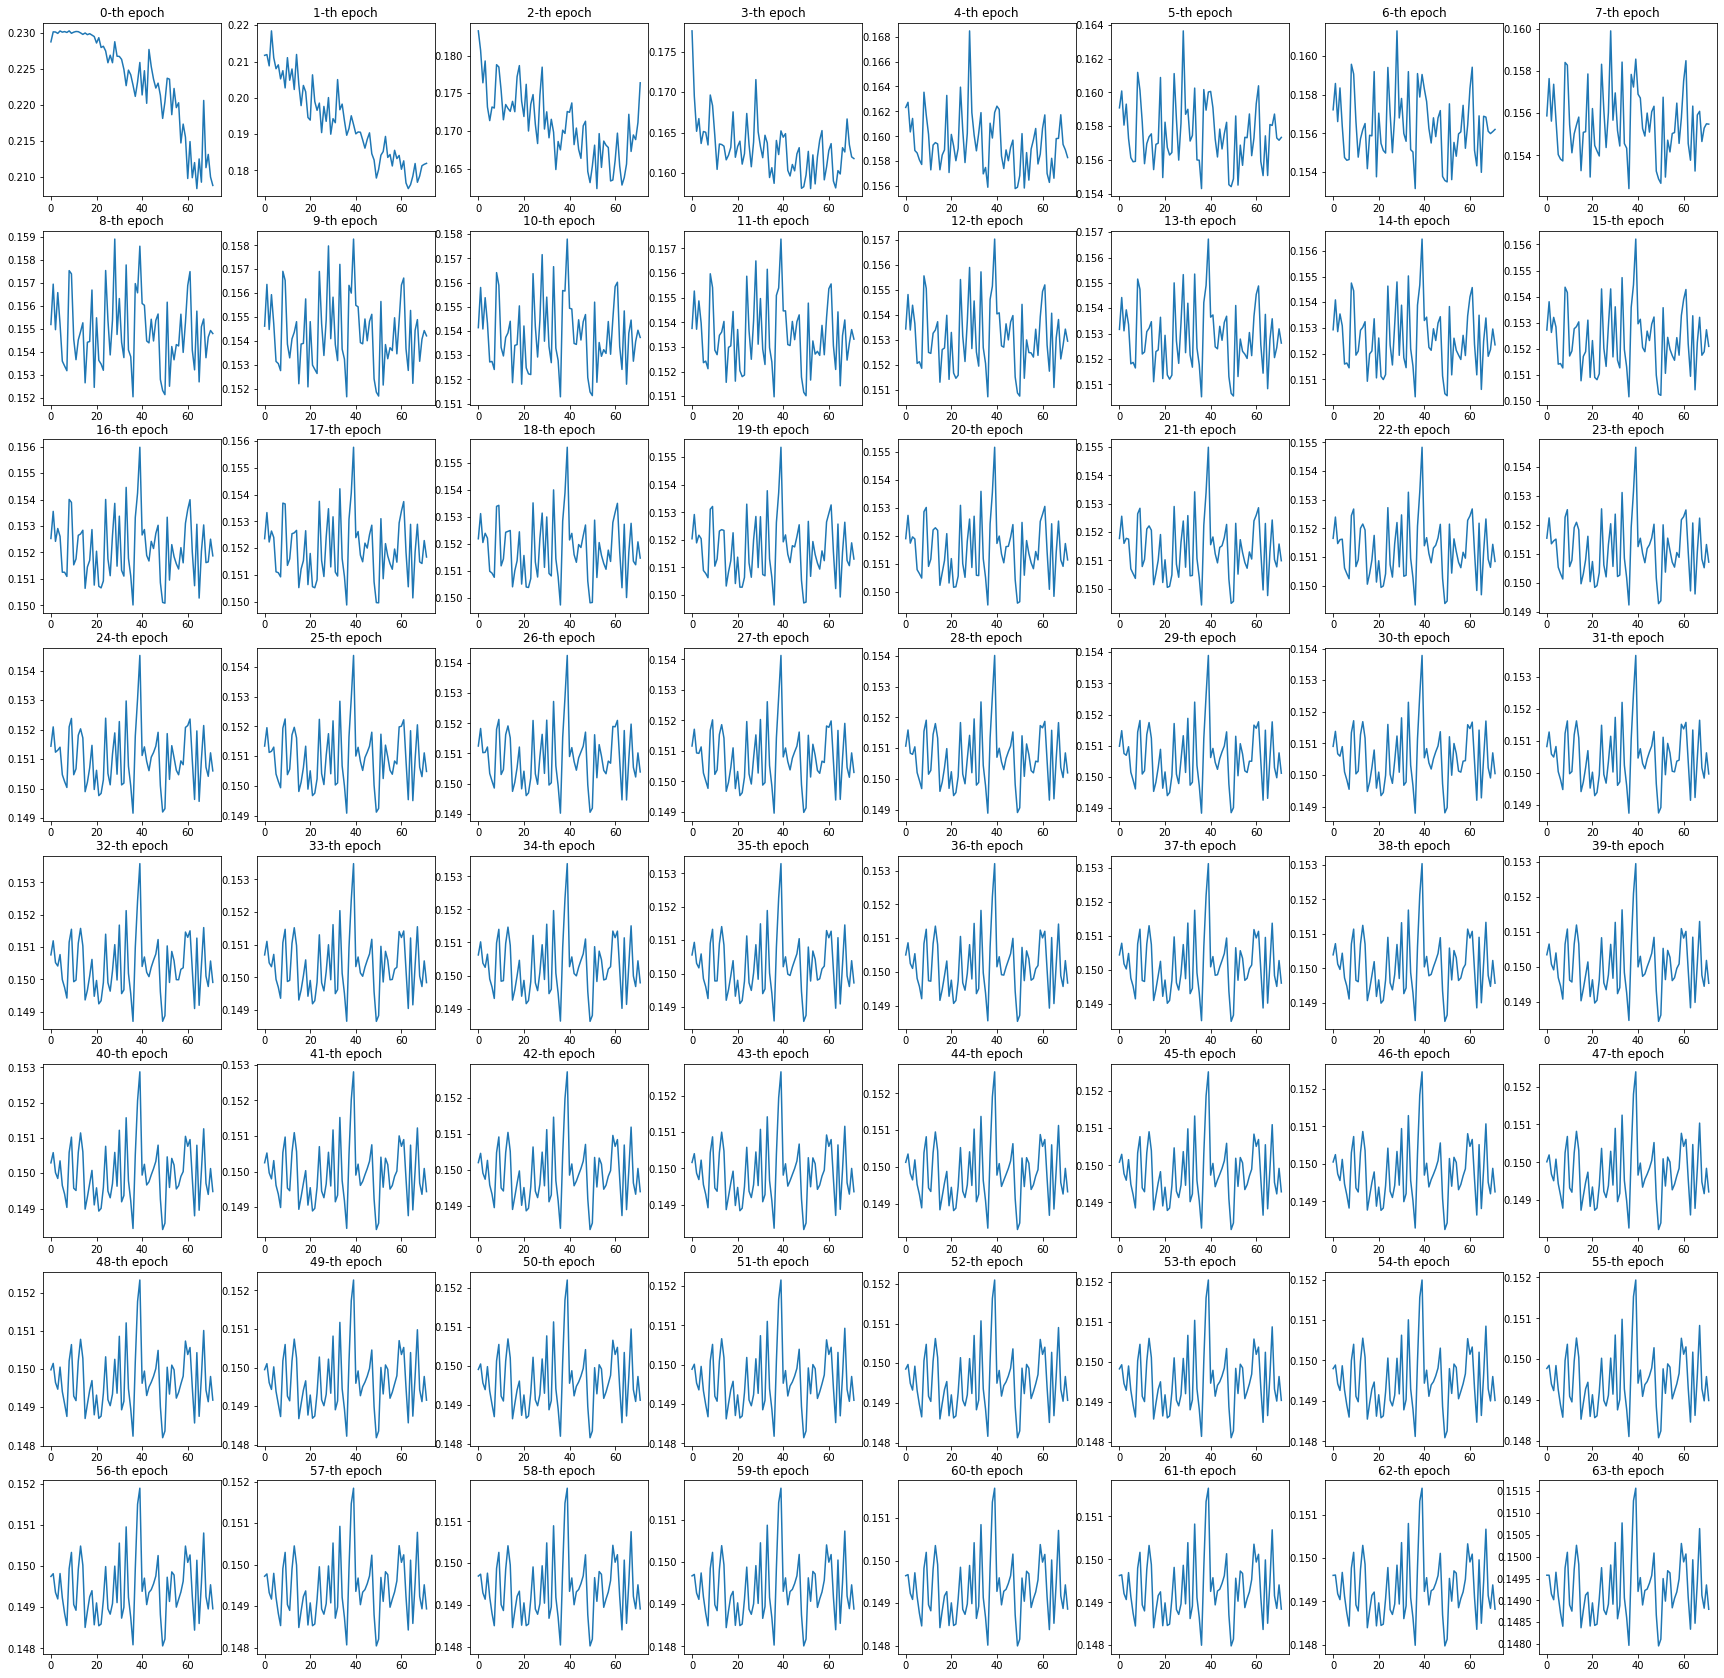

In [11]:
fig,axes = plt.subplots(8,8,figsize=(30,30))

for ep in range(64):
    row, col = divmod(ep, 8)
    axes[row, col].plot(result["loss"][ep])
    axes[row, col].set_title(f"{ep}-th epoch")

### Accuracy and Loss over epochs

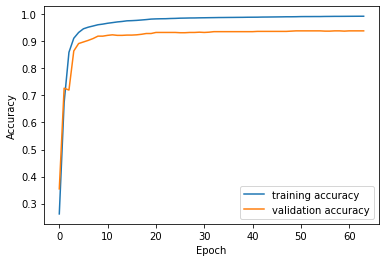

In [12]:
plt.plot(result["accuracy"].mean(1), label="training accuracy")
plt.plot(result["accuracy_val"], label="validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

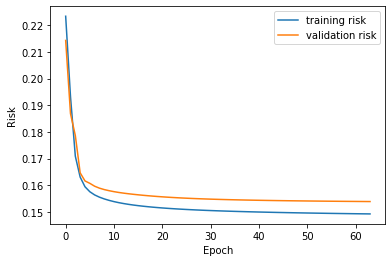

In [13]:
plt.plot(result["loss"].mean(1), label="training risk")
plt.plot(result["loss_val"], label="validation risk")
plt.xlabel("Epoch")
plt.ylabel("Risk")
plt.legend()
plt.show()

## Aribtrary Number of Layers

In [76]:
# 任意の層の数

"""
TODO/課題
- 一体化しているsoftmaxとcross entropyはモジュール化できていない
- lossをその都度内部で記録するようにする
- assertを入れる
- 分類にしか対応できていない
- validation dataを入れればbestのweightを保存するようにする
- forwardやpredの時に返す値を、zか、softmax(z)か、softmax(z).argmax()か、利便性を考えてベストなものに統一する。
- 活性化関数とその勾配（導関数）はセットでパターン化されているため、クラスにしていちいち入力する手間を減らすこともできる。
-　他の活性化関数（relu, tanh)や層(conv, maxpooling)も試す。
"""

"""
n_in: 入力層の次元
n_out: 出力層の次元
n_layers: 層の数。重みを調整するWの数。
n_hidden_nodes: 途中の層のnodeの数。
act_funcs:　各層の活性化関数。
grad_act_funcs: act_funcsの勾配関数。
lr: 学習率をエポックから求める関数。
init_std: Wを初期化するときの正規分布の標準偏差(np.random.normalのscaleパラメータ）の値。
"""

class Net:
    def __init__(self, n_in=784, n_out=10, n_layers=2, n_hidden_nodes=[64], act_funcs=[sigmoid, softmax], 
                 grad_act_funcs=[grad_sigmoid, -1],
                 lr=lambda epoch: (1e-2)/(1+epoch/8), init_std= 1e-3):
        
        assert len(n_hidden_nodes)+1==n_layers==len(act_funcs)==len(grad_act_funcs)
    
        self.n_nodes = [n_in]+n_hidden_nodes+[n_out]
        self.n_layers = n_layers
        self.act_funcs = act_funcs
        self.grad_act_funcs = grad_act_funcs
        self.W = [np.random.normal(0, init_std, (self.n_nodes[i+1], self.n_nodes[i]+1)) for i in range(n_layers)]
        self.lr = lr
        self.z = [0]*(n_layers+1)
        self.grad = [0]*n_layers
        
    def forward(self, x):
        self.z[0] = x
        for i in range(self.n_layers):
            if i: x = self.act_funcs[i-1](x)
            x = h(x)
            x = self.W[i] @ x
            self.z[i+1] = x
        self.y = self.act_funcs[-1](x)
        return self.z[-1]
    
    def backward(self, t):
        delta =  grad_cross_entropy_with_softmax(t, self.y)
        for i in range(self.n_layers-1):
            self.grad[-i-1] = delta @ h(self.act_funcs[-i-2](self.z[-i-2])).T
            delta = (self.W[-i-1][:,:-1].T @ delta) * self.grad_act_funcs[-i-2](self.z[-i-2])
        self.grad[0] = delta @ h(self.z[0]).T
        
    def update(self, epoch):
        for i in range(self.n_layers):
            self.W[i] -= self.lr(epoch)*self.grad[i]
            
    def predict(self, x):
        self.forward(x)
        return self.y.argmax(axis=0)

In [43]:
# verification (back propergation)
#　下の層でも誤差がほぼない
# 数値微分と照合したい時

net = Net(n_layers=3, n_hidden_nodes=[128,64], act_funcs=[sigmoid, sigmoid, softmax],
          grad_act_funcs=[grad_sigmoid, grad_sigmoid,-1])
i,j = 0,0

# 一回forward, backwardを回すことでgradが記録される
net.forward(X_train[:-1, :1])
net.backward(Y_one_hot_train[:, 0].reshape(-1,1))

# backpropagationの値
print("by backpropagation: ", net.grad[0][i, j])

# 数値微分の値
eps = 1e-3
net.W[0][i,j] += eps
L1 = cross_entropy_with_softmax(Y_train[:1], net.forward(X_train[:-1, :1])) 
net.W[0][i,j] -= 2*eps
L2 = cross_entropy_with_softmax(Y_train[:1], net.forward(X_train[:-1, :1]))
net.W[0][i,j] += eps

grad = (L1-L2)/(2*eps)
print("by numerical differentiation: ", *grad)

by backpropagation:  -2.607744717752419e-08
by numerical differentiation:  -2.6077584536210452e-08


In [77]:
# verify
# 層の数が大きくなると勾配消失のため学習しない

n_epoch = 64
batch_size = 128

#net = Net(n_layers=5, n_hidden_nodes=[64,64,64,64], act_funcs=[sigmoid, sigmoid, sigmoid, sigmoid,softmax],
#          grad_act_funcs=[grad_sigmoid, grad_sigmoid,grad_sigmoid,grad_sigmoid,-1])

net = Net(n_layers=3, n_hidden_nodes=[64,64], act_funcs=[sigmoid, sigmoid, softmax],
          grad_act_funcs=[grad_sigmoid, grad_sigmoid, -1])

result = {"accuracy": np.zeros((n_epoch, n_train//batch_size)),
         "loss": np.zeros((n_epoch, n_train//batch_size)),
         "accuracy_val": np.zeros(n_epoch),
         "loss_val": np.zeros(n_epoch)}

best_acc = 0
best_weight = -1
for ep in range(n_epoch):
    for i in range(n_train//batch_size):
        X_batch = X_train[:-1, i*batch_size:(i+1)*batch_size]
        Y_batch = Y_train[i*batch_size:(i+1)*batch_size]
        Y_one_hot_batch = Y_one_hot_train[:, i*batch_size:(i+1)*batch_size]
        
        net.forward(X_batch)
        net.backward(Y_one_hot_batch)
        net.update(ep)
        
        # accuracy on training batch
        pred = softmax(net.forward(X_batch))
        acc = (pred.argmax(axis=0)==Y_batch).mean()
        loss = cross_entropy_with_softmax(Y_batch, pred).sum() / batch_size / C
        
        result["accuracy"][ep][i] = acc
        result["loss"][ep][i] = loss
        
    # validation
    pred = softmax(net.forward(X_val[:-1,:]))
    acc = (pred.argmax(axis=0)==Y_val).mean()
    loss = cross_entropy_with_softmax(Y_val, pred).sum() / len(Y_val) / C
    
    result["accuracy_val"][ep] = acc
    result["loss_val"][ep] = loss
    
    print(f"{ep}-th epoch")
    print("Validation Accuracy: ", acc)
    print("Validation Loss: ", loss)

0-th epoch
Validation Accuracy:  0.095703125
Validation Loss:  0.2302124392306924
1-th epoch
Validation Accuracy:  0.2548828125
Validation Loss:  0.22470302205817286
2-th epoch
Validation Accuracy:  0.275390625
Validation Loss:  0.22284372664628527
3-th epoch
Validation Accuracy:  0.3203125
Validation Loss:  0.22011825743894242
4-th epoch
Validation Accuracy:  0.375
Validation Loss:  0.21739684663216155
5-th epoch
Validation Accuracy:  0.419921875
Validation Loss:  0.21584318191963572
6-th epoch
Validation Accuracy:  0.427734375
Validation Loss:  0.21465849807147777
7-th epoch
Validation Accuracy:  0.4482421875
Validation Loss:  0.21322797874232768
8-th epoch
Validation Accuracy:  0.4765625
Validation Loss:  0.21065599895207274
9-th epoch
Validation Accuracy:  0.5029296875
Validation Loss:  0.20690193714252195
10-th epoch
Validation Accuracy:  0.5244140625
Validation Loss:  0.20261738412640148
11-th epoch
Validation Accuracy:  0.5576171875
Validation Loss:  0.19931115523542575
12-th ep